# 센서 시퀀스 데이터 EDA
클린 샘플 리스트를 기반으로 센서 시퀀스의 길이, 분산, peak 존재 여부를 분석합니다.

## 1. 필요 라이브러리 임포트
데이터 분석에 필요한 pandas, numpy, matplotlib, scipy 등을 임포트합니다.

In [6]:
# 1. 필요 라이브러리 임포트
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from tqdm import tqdm


plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

## 2. 센서 시퀀스 데이터 불러오기
클린 샘플 리스트와 각 샘플의 센서 시퀀스 데이터를 불러옵니다.

In [7]:
# 2. 센서 시퀀스 데이터 불러오기
clean_csv_path = '../EDA/train_clean.csv'
df_clean = pd.read_csv(clean_csv_path)

# 센서 시퀀스 파일 경로 생성 함수 (예시)
def get_sensor_seq_path(cls, sample_id):
    return f"../data/train/raw/sensor/{cls}/N/{sample_id}/{sample_id}.csv"

df_clean['sensor_seq_path'] = df_clean.apply(lambda row: get_sensor_seq_path(row['class'], row['sample_id']), axis=1)

def load_sensor_sequence(path):
    if not os.path.exists(path):
        return None
    try:
        return pd.read_csv(path).values
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None

df_clean['sensor_sequence'] = df_clean['sensor_seq_path'].apply(load_sensor_sequence)
display(df_clean[['sample_id', 'class', 'sensor_seq_path', 'sensor_sequence']].head())

,sample_id,class,sensor_seq_path,sensor_sequence
0,02181_H_A_N_C1,N,../data/train/raw/sensor/N/N/02181_H_A_N_C1/02...,"[[1.0, 0.0094653854016316, 0.782734528353082, ..."
1,02117_H_A_N_C6,N,../data/train/raw/sensor/N/N/02117_H_A_N_C6/02...,"[[1.0, 0.288013582038267, 0.115596204073747, 0..."
2,02497_H_A_N_C5,N,../data/train/raw/sensor/N/N/02497_H_A_N_C5/02...,"[[1.0, -0.0769675132119568, -0.184727678686251..."
3,02604_H_A_N_C2,N,../data/train/raw/sensor/N/N/02604_H_A_N_C2/02...,"[[1.0, 0.417590633685756, -0.697036718852847, ..."
4,00322_H_A_N_C3,N,../data/train/raw/sensor/N/N/00322_H_A_N_C3/00...,"[[1.0, -0.0783127804777862, -0.028407968290283..."


## 3. 시퀀스 길이 분석
각 센서 시퀀스의 길이를 계산하고, 분포를 시각화합니다.

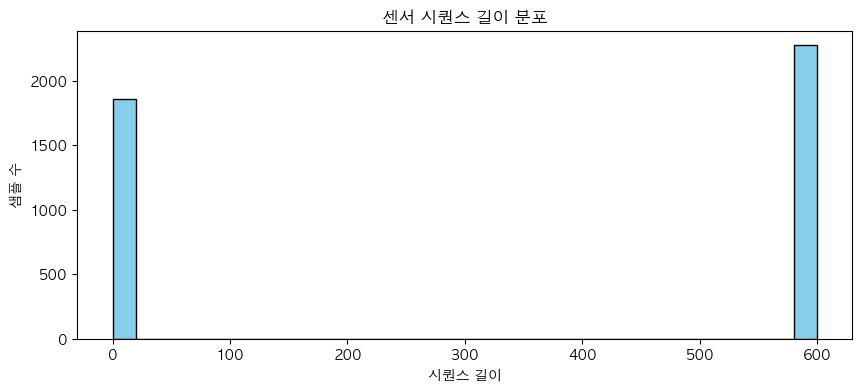

count    4128.000000
mean      330.232558
std       298.508925
min         0.000000
25%         0.000000
50%       600.000000
75%       600.000000
max       600.000000
Name: seq_length, dtype: float64


In [8]:
# 3. 시퀀스 길이 분석
# 각 시퀀스의 길이 계산
df_clean['seq_length'] = df_clean['sensor_sequence'].apply(lambda x: len(x) if x is not None else 0)

plt.figure(figsize=(10,4))
plt.hist(df_clean['seq_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('센서 시퀀스 길이 분포')
plt.xlabel('시퀀스 길이')
plt.ylabel('샘플 수')
plt.show()

print(df_clean['seq_length'].describe())

## 4. 시퀀스 분산 계산
각 시퀀스의 분산을 계산하여 통계적으로 분석합니다.

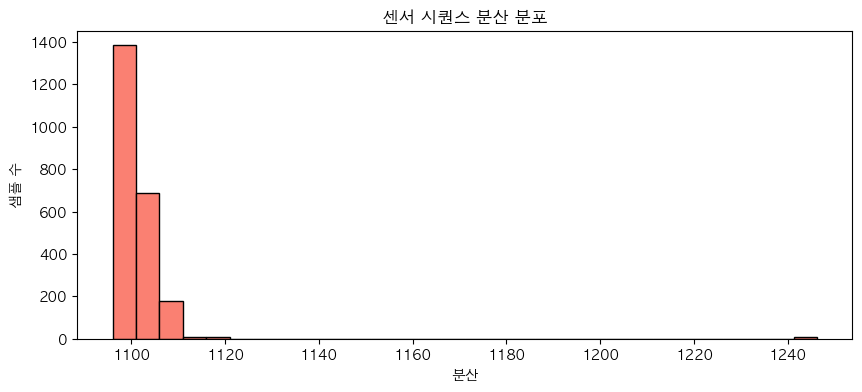

count    2272.000000
mean     1101.202373
std         9.390844
min      1096.023100
25%      1097.875743
50%      1100.030049
75%      1102.678815
max      1246.250817
Name: seq_variance, dtype: float64


In [9]:
# 4. 시퀀스 분산 계산
# 각 시퀀스의 분산 계산 (전체 센서값 기준)
def calc_variance(seq):
    if seq is None or len(seq) == 0:
        return np.nan
    return np.var(seq)

df_clean['seq_variance'] = df_clean['sensor_sequence'].apply(calc_variance)

plt.figure(figsize=(10,4))
plt.hist(df_clean['seq_variance'].dropna(), bins=30, color='salmon', edgecolor='black')
plt.title('센서 시퀀스 분산 분포')
plt.xlabel('분산')
plt.ylabel('샘플 수')
plt.show()

print(df_clean['seq_variance'].describe())

## 5. Peak 존재 여부 탐지
각 시퀀스에서 peak(최대값) 존재 여부를 탐지하고, 결과를 요약합니다.

In [10]:
# 5. Peak 존재 여부 탐지
# 각 시퀀스에서 peak(최대값) 존재 여부 탐지 (기본적으로 1개 이상 peak가 있으면 True)
def has_peak(seq, threshold=1.0):
    if seq is None or len(seq) == 0:
        return False
    # 1차원 시퀀스만 처리 (여러 센서값이면 첫 번째 컬럼 기준)
    arr = seq[:,0] if len(seq.shape) > 1 else seq
    peaks, _ = find_peaks(arr, height=threshold)
    return len(peaks) > 0

df_clean['has_peak'] = df_clean['sensor_sequence'].apply(has_peak)

peak_ratio = df_clean['has_peak'].mean()
print(f"Peak 존재 샘플 비율: {peak_ratio:.2%}")
print(df_clean['has_peak'].value_counts())

Peak 존재 샘플 비율: 0.00%
has_peak
False    4128
Name: count, dtype: int64
